# Time-Series Clustering with TS2Vec (Pretrained Representation)
Small CPU demo using TS2Vec self-supervised encoder, then KMeans on embeddings. For larger datasets/GPU, run in Colab.

In [1]:
!pip install -q ts2vec scikit-learn matplotlib

zsh:1: command not found: pip


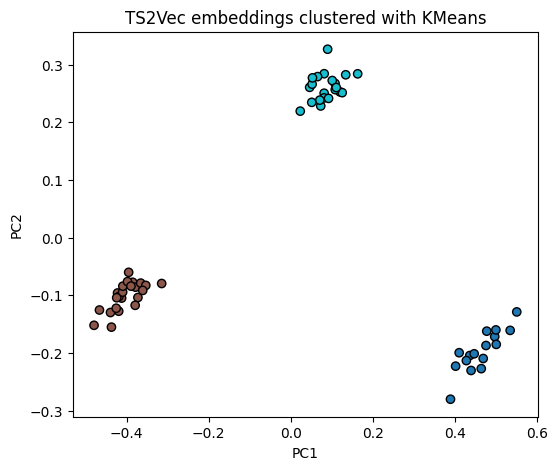

Cluster counts: [16 23 21]
True pattern counts: [21 23 16]


In [2]:

import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from ts2vec.ts2vec import TS2Vec

# synthetic multivariate time-series: three patterns
rs = np.random.RandomState(42)
N = 60
L = 80
# pattern A: sine
t = np.linspace(0, 4*np.pi, L)
pat_a = np.sin(t)
# pattern B: square-ish
pat_b = np.sign(np.sin(t))
# pattern C: ramp
pat_c = np.linspace(-1,1,L)
series = []
labels_true = []
for i in range(N):
    base = rs.choice([0,1,2])
    noise = rs.normal(0,0.1,L)
    if base==0:
        s=pat_a+noise
    elif base==1:
        s=pat_b+noise
    else:
        s=pat_c+noise
    series.append(s[:,None])
    labels_true.append(base)
X = np.stack(series)  # (N, L, 1)

# Train TS2Vec (small, CPU). Reduce iters for speed.
model = TS2Vec(input_dims=1, output_dims=64, hidden_dims=32, depth=4, device="cpu", batch_size=16)
model.fit(X, n_iters=20, verbose=False)
emb = model.encode(X, encoding_window='full_series')

# Cluster embeddings
km = KMeans(n_clusters=3, random_state=42, n_init='auto').fit(emb)
labels_pred = km.labels_

# Visualize embeddings with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit_transform(emb)
plt.figure(figsize=(6,5))
plt.scatter(pca[:,0], pca[:,1], c=labels_pred, cmap='tab10', edgecolor='k')
plt.title('TS2Vec embeddings clustered with KMeans')
plt.xlabel('PC1'); plt.ylabel('PC2');
plt.show()

print('Cluster counts:', np.bincount(labels_pred))
print('True pattern counts:', np.bincount(labels_true))
